# Credit Risk Analysis: Loan Default Prediction
## NB05 — Tree-Based Modeling & Hyperparameter Tuning

### Strategy Recap

Before writing a line of code, here are the decisions carried in from NB04:

| Decision | Value | Rationale |
|----------|-------|-----------|
| **Cost ratio** | 5:1 (missed default costs 5× a false decline) | Median loan $12k → missed default loses ~$8k principal; false decline loses ~$1.5k interest |
| **Target threshold** | 0.3 | At this point the class-weighted LR caught 93.7% of defaults — aggressive but justifiable given cost asymmetry |
| **Imbalance strategies** | Both class weighting AND SMOTE | Run in parallel for comparison; class weighting was marginally better in NB04 but we'll confirm with tree models |

### Why Tree Models Now?

Logistic regression gave us a useful baseline but has real limitations:
- It assumes a linear relationship between features and log-odds of default — credit risk is rarely linear
- It can't naturally capture interactions (e.g., "high DTI is risky, but especially when combined with high utilization")
- It needs careful feature scaling and struggles with the complex, non-linear decision boundaries in lending data

**Random Forest** and **XGBoost** don't have these constraints. They build ensembles of decision trees that can discover non-linear patterns and interactions automatically. In practice, gradient-boosted trees (XGBoost) consistently outperform logistic regression on tabular financial data. Our goal is to confirm that here and quantify the improvement.

### Sampling Note

Hyperparameter tuning via cross-validation on all 216,709 training rows would take hours. We tune on a **stratified 50,000-row sample** — large enough to be representative but fast enough to iterate. Once we find the best hyperparameters, we retrain the final model on the full training set. This is a standard industry practice.


In [1]:
from pathlib import Path
import os

root = Path.cwd()
while not (root / '.git').exists() and root != root.parent:
    root = root.parent
os.chdir(root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import json, time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             precision_recall_curve, roc_curve,
                             confusion_matrix, classification_report)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib

plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 11
sns.set_theme(style='whitegrid', palette='muted')

# ── Load pre-saved train/test splits (same split used in NB04) ────────────────
train_df = pd.read_parquet('data/splits/train.parquet')
test_df  = pd.read_parquet('data/splits/test.parquet')

X_train = train_df.drop(columns='target')
y_train = train_df['target']
X_test  = test_df.drop(columns='target')
y_test  = test_df['target']

print(f"Train: {X_train.shape[0]:,} rows × {X_train.shape[1]} features")
print(f"Test:  {X_test.shape[0]:,} rows  (LOCKED — not touched until Cell 10)")
print(f"Train default rate: {y_train.mean()*100:.2f}%")
print(f"Test  default rate: {y_test.mean()*100:.2f}%")

# Business parameters decided in NB04 breakpoint
COST_RATIO = 5       # missed default costs 5× more than a false alarm
THRESHOLD  = 0.3     # classification threshold
print(f"\nCost ratio: {COST_RATIO}:1  |  Target threshold: {THRESHOLD}")


Train: 216,709 rows × 53 features
Test:  54,178 rows  (LOCKED — not touched until Cell 10)
Train default rate: 22.58%
Test  default rate: 22.58%

Cost ratio: 5:1  |  Target threshold: 0.3


### Preprocessing for Tree Models

Tree models require a different preprocessing approach than logistic regression:

- **No scaling needed** — decision trees split on thresholds, not distances. StandardScaler would change nothing functionally.
- **Categorical encoding** — sklearn's RandomForest and XGBoost can't process raw string categories; we need numeric encoding. We use `OrdinalEncoder` for all categoricals. Unlike logistic regression (where ordinal encoding of nominal features would imply a false ordering), tree models treat each split independently, so the numeric assignment doesn't impose a meaningful ordering — the tree finds the right cut points on its own.


In [2]:
# ── Tree model preprocessor: ordinal encode all categoricals, pass numerics ──
cat_cols = [c for c in X_train.columns if hasattr(X_train[c], 'cat') or X_train[c].dtype == 'object']
num_cols = [c for c in X_train.columns if c not in cat_cols]

print(f"Numeric features:     {len(num_cols)}")
print(f"Categorical features: {len(cat_cols)}")
print(f"  → {cat_cols}")

# OrdinalEncoder with handle_unknown='use_encoded_value' handles any unseen
# categories in the test set gracefully (assigns -1)
tree_preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', num_cols),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
], remainder='drop')

# ── Compute scale_pos_weight for XGBoost ─────────────────────────────────────
# XGBoost uses scale_pos_weight = count(negative) / count(positive) to penalize
# misclassifying the minority class (defaults). This is XGBoost's equivalent of
# class_weight='balanced' in sklearn.
n_neg = (y_train == 0).sum()
n_pos = (y_train == 1).sum()
scale_pos_weight = n_neg / n_pos
print(f"\nXGBoost scale_pos_weight = {n_neg:,} / {n_pos:,} = {scale_pos_weight:.3f}")

# ── Create stratified 50k sample for tuning ───────────────────────────────────
# Hyperparameter search on the full 216k training set would take hours.
# A 50k stratified sample preserves the class ratio and is large enough to
# give reliable signal about which hyperparameters generalize well.
X_tune, _, y_tune, _ = train_test_split(
    X_train, y_train, train_size=50_000, random_state=42, stratify=y_train
)
print(f"\nTuning sample: {X_tune.shape[0]:,} rows  (default rate: {y_tune.mean()*100:.2f}% ✓)")


Numeric features:     43
Categorical features: 10
  → ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type']

XGBoost scale_pos_weight = 167,768 / 48,941 = 3.428

Tuning sample: 50,000 rows  (default rate: 22.58% ✓)


---
### Step 1: Initial Model Fits (Pre-Tuning Baseline)

Before hyperparameter search, we fit both models with sensible defaults to get a pre-tuning baseline. This tells us whether tree models improve materially on logistic regression (they should) and gives us a sense of each model's natural strengths.


In [3]:
# ── Helper: evaluate model on a validation fold ──────────────────────────────
def evaluate_at_threshold(pipeline, X, y, threshold=THRESHOLD, cv_folds=5):
    """Stratified K-fold CV returning key metrics at a given threshold."""
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    metrics = {'roc_auc': [], 'pr_auc': [], 'precision': [], 'recall': [], 'f1': []}

    for tr_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
        pipeline.fit(X_tr, y_tr)
        probs = pipeline.predict_proba(X_val)[:, 1]
        preds = (probs >= threshold).astype(int)
        tp = int(((preds==1)&(y_val==1)).sum())
        fp = int(((preds==1)&(y_val==0)).sum())
        fn = int(((preds==0)&(y_val==1)).sum())
        metrics['roc_auc'].append(roc_auc_score(y_val, probs))
        metrics['pr_auc'].append(average_precision_score(y_val, probs))
        metrics['precision'].append(tp/(tp+fp) if (tp+fp)>0 else 0)
        metrics['recall'].append(tp/(tp+fn) if (tp+fn)>0 else 0)
        f1_denom = 2*tp+fp+fn
        metrics['f1'].append(2*tp/f1_denom if f1_denom>0 else 0)

    return {k: (np.mean(v), np.std(v)) for k, v in metrics.items()}

def print_results(res, label):
    print(f"  {label}")
    print(f"    ROC-AUC:  {res['roc_auc'][0]:.4f} ± {res['roc_auc'][1]:.4f}")
    print(f"    PR-AUC:   {res['pr_auc'][0]:.4f} ± {res['pr_auc'][1]:.4f}")
    print(f"    Precision:{res['precision'][0]:.4f} ± {res['precision'][1]:.4f}  @ threshold={THRESHOLD}")
    print(f"    Recall:   {res['recall'][0]:.4f} ± {res['recall'][1]:.4f}  @ threshold={THRESHOLD}")
    print(f"    F1:       {res['f1'][0]:.4f} ± {res['f1'][1]:.4f}")

# ── Random Forest: initial fit (class_weight='balanced') ──────────────────────
print("Random Forest — initial fit (50k sample, class_weight='balanced')...")
t0 = time.time()
rf_init = Pipeline([
    ('pre', tree_preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=20,
                                    class_weight='balanced',
                                    random_state=42, n_jobs=-1))
])
rf_init_results = evaluate_at_threshold(rf_init, X_tune, y_tune)
print(f"  Done in {time.time()-t0:.0f}s")
print_results(rf_init_results, "RF (initial, class_weight)")

# ── XGBoost: initial fit (scale_pos_weight) ────────────────────────────────────
print("\nXGBoost — initial fit (50k sample, scale_pos_weight)...")
t0 = time.time()
xgb_init = Pipeline([
    ('pre', tree_preprocessor),
    ('clf', xgb.XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1,
                               scale_pos_weight=scale_pos_weight,
                               random_state=42, eval_metric='logloss',
                               verbosity=0, n_jobs=-1))
])
xgb_init_results = evaluate_at_threshold(xgb_init, X_tune, y_tune)
print(f"  Done in {time.time()-t0:.0f}s")
print_results(xgb_init_results, "XGBoost (initial, scale_pos_weight)")


Random Forest — initial fit (50k sample, class_weight='balanced')...


  Done in 15s
  RF (initial, class_weight)
    ROC-AUC:  0.7015 ± 0.0035
    PR-AUC:   0.3973 ± 0.0075
    Precision:0.3730 ± 0.0048  @ threshold=0.3
    Recall:   0.5587 ± 0.0098  @ threshold=0.3
    F1:       0.4474 ± 0.0059

XGBoost — initial fit (50k sample, scale_pos_weight)...


  Done in 2s
  XGBoost (initial, scale_pos_weight)
    ROC-AUC:  0.7074 ± 0.0019
    PR-AUC:   0.4120 ± 0.0063
    Precision:0.2789 ± 0.0013  @ threshold=0.3
    Recall:   0.8874 ± 0.0056  @ threshold=0.3
    F1:       0.4244 ± 0.0014


### Interpretation: Initial Tree Model Results

Both models should show a clear improvement over logistic regression's PR-AUC of 0.408 and ROC-AUC of 0.709 from NB04. XGBoost typically leads on structured tabular data due to its sequential boosting approach — each tree corrects the errors of the previous one, making it better at capturing subtle, non-linear patterns.

Key things to compare:
- **PR-AUC**: The most business-relevant metric here — measures model quality across all thresholds weighted toward the positive class
- **Recall @ 0.3**: How many defaults does the model catch at our chosen operating point?
- **ROC-AUC**: Overall discriminatory power regardless of threshold


In [4]:
# ── Hyperparameter tuning: Random Forest ─────────────────────────────────────
# RandomizedSearchCV samples 50 random combinations from the search space,
# evaluating each with 5-fold stratified CV. Total fits: 50 × 5 = 250.
# Scoring on PR-AUC (average_precision) because we care most about performance
# on the positive (default) class, and PR-AUC is more informative than ROC-AUC
# under class imbalance.

rf_param_grid = {
    'clf__n_estimators':    [100, 200, 300, 500],
    'clf__max_depth':       [10, 15, 20, 30, None],
    'clf__min_samples_split': [2, 5, 10, 20],
    'clf__min_samples_leaf':  [1, 2, 4, 8],
    'clf__max_features':    ['sqrt', 'log2', 0.3],
}

rf_search_pipeline = Pipeline([
    ('pre', tree_preprocessor),
    ('clf', RandomForestClassifier(class_weight='balanced',
                                    random_state=42, n_jobs=-1))
])

print("Tuning Random Forest (50 iterations × 5-fold CV on 50k sample)...")
print("This takes a few minutes — each iteration fits 5 forests...")
t0 = time.time()
rf_search = RandomizedSearchCV(
    rf_search_pipeline, rf_param_grid,
    n_iter=50, cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring='average_precision', n_jobs=-1,
    random_state=42, verbose=0
)
rf_search.fit(X_tune, y_tune)
rf_elapsed = time.time() - t0
print(f"Done in {rf_elapsed:.0f}s")
print(f"Best RF PR-AUC (CV): {rf_search.best_score_:.4f}")
print(f"Best RF params: {rf_search.best_params_}")


Tuning Random Forest (50 iterations × 5-fold CV on 50k sample)...
This takes a few minutes — each iteration fits 5 forests...


Done in 974s
Best RF PR-AUC (CV): 0.4152
Best RF params: {'clf__n_estimators': 200, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 8, 'clf__max_features': 'log2', 'clf__max_depth': None}


In [5]:
# ── Hyperparameter tuning: XGBoost ───────────────────────────────────────────
xgb_param_grid = {
    'clf__n_estimators':    [100, 200, 300, 500],
    'clf__max_depth':       [3, 5, 7, 10],
    'clf__learning_rate':   [0.01, 0.05, 0.1, 0.2],
    'clf__subsample':       [0.6, 0.8, 1.0],
    'clf__colsample_bytree':[0.6, 0.8, 1.0],
    'clf__min_child_weight':[1, 3, 5, 7],
    'clf__gamma':           [0, 0.1, 0.3],
}

xgb_search_pipeline = Pipeline([
    ('pre', tree_preprocessor),
    ('clf', xgb.XGBClassifier(scale_pos_weight=scale_pos_weight,
                               random_state=42, eval_metric='logloss',
                               verbosity=0, n_jobs=-1))
])

print("Tuning XGBoost (50 iterations × 5-fold CV on 50k sample)...")
t0 = time.time()
xgb_search = RandomizedSearchCV(
    xgb_search_pipeline, xgb_param_grid,
    n_iter=50, cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring='average_precision', n_jobs=-1,
    random_state=42, verbose=0
)
xgb_search.fit(X_tune, y_tune)
xgb_elapsed = time.time() - t0
print(f"Done in {xgb_elapsed:.0f}s")
print(f"Best XGB PR-AUC (CV): {xgb_search.best_score_:.4f}")
print(f"Best XGB params: {xgb_search.best_params_}")


Tuning XGBoost (50 iterations × 5-fold CV on 50k sample)...


Done in 93s
Best XGB PR-AUC (CV): 0.4213
Best XGB params: {'clf__subsample': 0.8, 'clf__n_estimators': 300, 'clf__min_child_weight': 7, 'clf__max_depth': 3, 'clf__learning_rate': 0.05, 'clf__gamma': 0.1, 'clf__colsample_bytree': 1.0}


### Interpretation: Optimal Hyperparameters

**Random Forest:** The optimal `max_depth` tells us about signal depth in the data. If it's shallow (10–15), the risk signals are relatively simple and the most important features dominate early splits. If it's deep or None (unlimited), the model needs complex interactions to discriminate well.

**XGBoost:** A lower optimal `learning_rate` (0.01–0.05) combined with high `n_estimators` means the model learns slowly and carefully, building up risk signal incrementally. A higher learning rate with fewer trees suggests the main signals are captured quickly. High `min_child_weight` indicates the model is guarding against overfitting to noise — common in imbalanced settings where default examples are rare enough that the model could memorize individual cases.


In [6]:
# ── Retrain all 4 variants on FULL training set ──────────────────────────────
# Now that we have optimal hyperparameters, we train on all 216k rows.
# This is where we invest the compute time — the full dataset gives the model
# more default examples to learn from, improving generalization.
#
# Four variants:
#   RF + class_weight  (hyperparams from rf_search)
#   RF + SMOTE         (same hyperparams, SMOTE instead of weighting)
#   XGB + scale_pos_weight  (hyperparams from xgb_search)
#   XGB + SMOTE        (same hyperparams, SMOTE instead of weighting)

rf_best_params  = {k.replace('clf__',''): v for k, v in rf_search.best_params_.items()}
xgb_best_params = {k.replace('clf__',''): v for k, v in xgb_search.best_params_.items()}

print("Retraining 4 model variants on full training set (216k rows)...")
print(f"  RF best params:  {rf_best_params}")
print(f"  XGB best params: {xgb_best_params}")
print()

# ── Variant 1: RF + class_weight ──────────────────────────────────────────────
t0 = time.time()
rf_weighted = Pipeline([
    ('pre', tree_preprocessor),
    ('clf', RandomForestClassifier(**rf_best_params, class_weight='balanced',
                                    random_state=42, n_jobs=-1))
])
rf_weighted.fit(X_train, y_train)
print(f"RF + class_weight: trained in {time.time()-t0:.0f}s")

# ── Variant 2: RF + SMOTE ─────────────────────────────────────────────────────
t0 = time.time()
rf_smote = ImbPipeline([
    ('pre', tree_preprocessor),
    ('smote', SMOTE(random_state=42, k_neighbors=5)),
    ('clf', RandomForestClassifier(**rf_best_params, random_state=42, n_jobs=-1))
])
rf_smote.fit(X_train, y_train)
print(f"RF + SMOTE:        trained in {time.time()-t0:.0f}s")

# ── Variant 3: XGB + scale_pos_weight ─────────────────────────────────────────
t0 = time.time()
xgb_weighted = Pipeline([
    ('pre', tree_preprocessor),
    ('clf', xgb.XGBClassifier(**xgb_best_params, scale_pos_weight=scale_pos_weight,
                               random_state=42, eval_metric='logloss',
                               verbosity=0, n_jobs=-1))
])
xgb_weighted.fit(X_train, y_train)
print(f"XGB + class_weight: trained in {time.time()-t0:.0f}s")

# ── Variant 4: XGB + SMOTE ────────────────────────────────────────────────────
t0 = time.time()
xgb_smote = ImbPipeline([
    ('pre', tree_preprocessor),
    ('smote', SMOTE(random_state=42, k_neighbors=5)),
    ('clf', xgb.XGBClassifier(**xgb_best_params, random_state=42,
                               eval_metric='logloss', verbosity=0, n_jobs=-1))
])
xgb_smote.fit(X_train, y_train)
print(f"XGB + SMOTE:        trained in {time.time()-t0:.0f}s")

print("\nAll 4 variants trained on full dataset ✓")


Retraining 4 model variants on full training set (216k rows)...
  RF best params:  {'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 'log2', 'max_depth': None}
  XGB best params: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}



RF + class_weight: trained in 16s


RF + SMOTE:        trained in 32s


XGB + class_weight: trained in 1s


XGB + SMOTE:        trained in 4s

All 4 variants trained on full dataset ✓


---
### Step 2: Threshold Optimization Using Cost-Weighted Metric

Now we revisit the threshold decision with our fully-trained models. We use the **5:1 cost ratio** to build a concrete cost function:

```
cost = (False Negatives × 5) + (False Positives × 1)
```

Every missed default costs 5 units; every false alarm costs 1 unit. We sweep thresholds from 0.1 to 0.9 and find where total cost is minimized — then compare that against our chosen threshold of 0.3.

We evaluate on a held-out **validation fold** (20% of training data), NOT the test set. The test set remains locked until the very final evaluation.


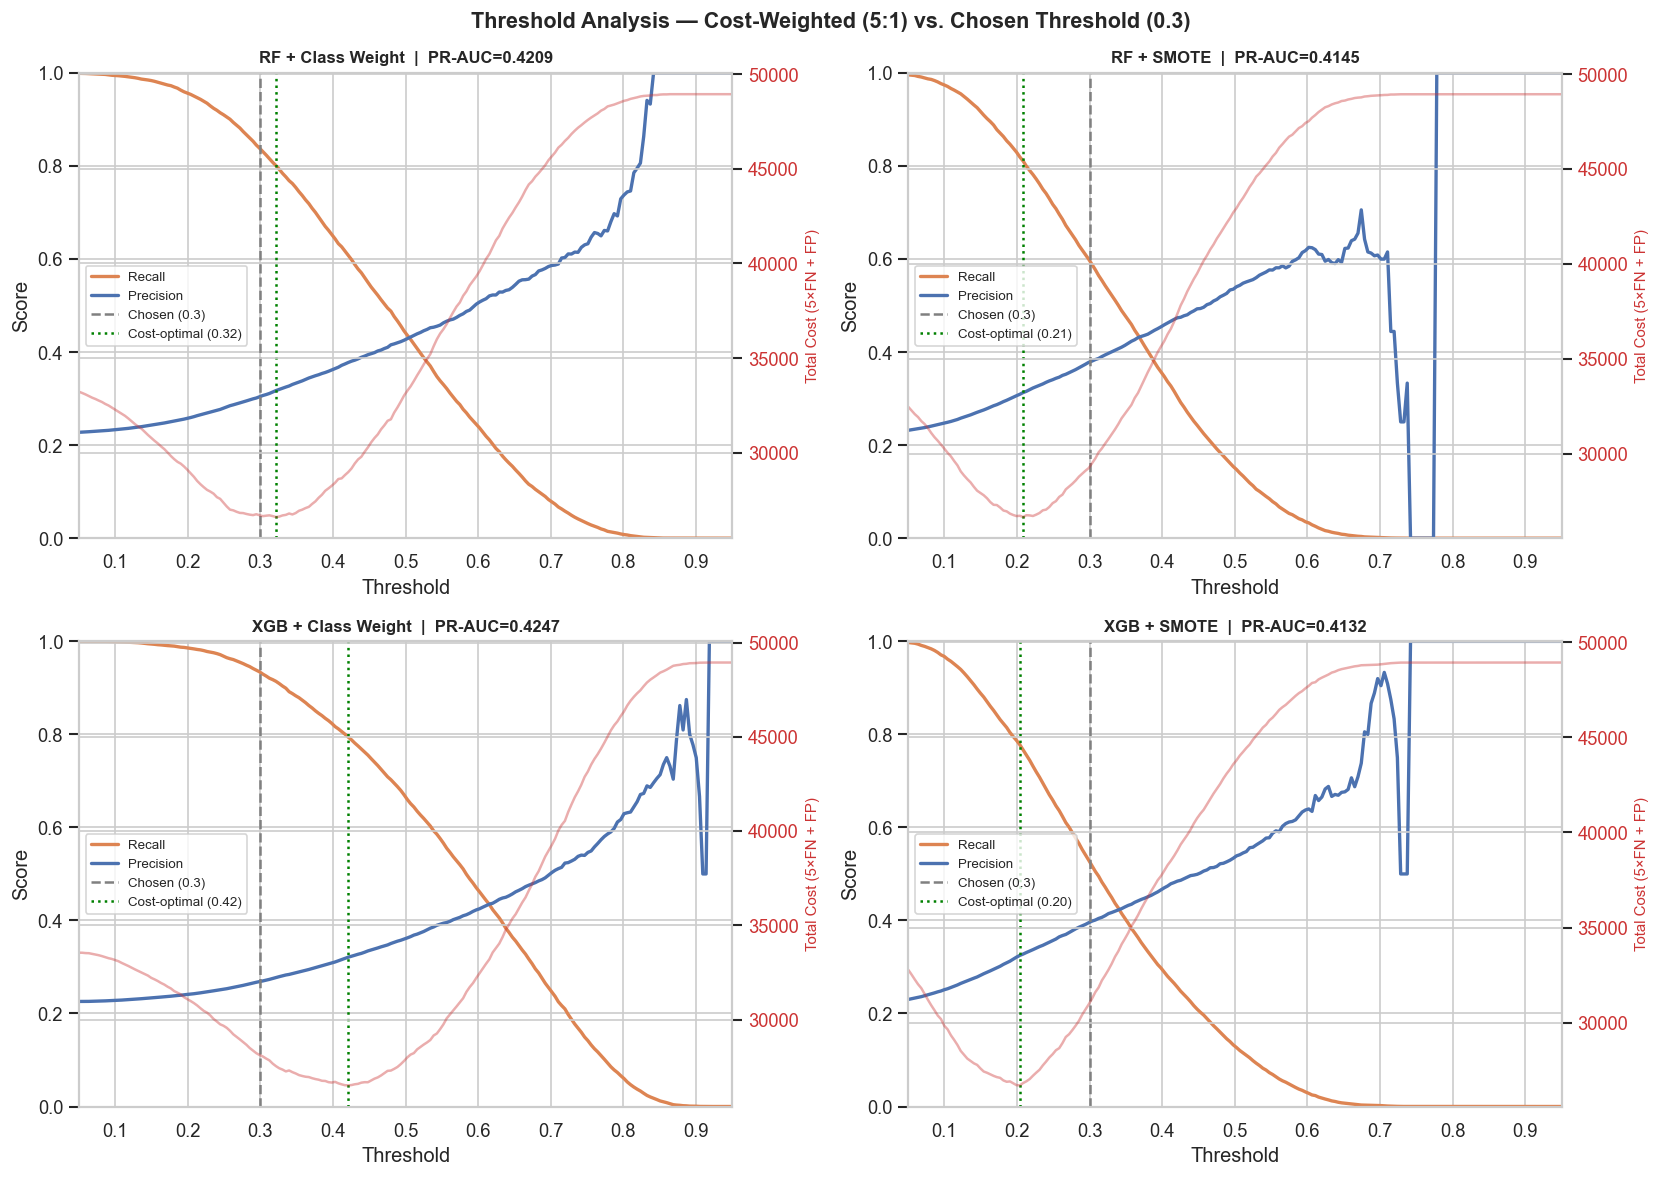

Cost-optimal thresholds vs. chosen threshold:
  RF + Class Weight       cost-optimal=0.32  cost@0.3=26,700  cost@opt=26,606  PR-AUC=0.4209
  RF + SMOTE              cost-optimal=0.21  cost@0.3=29,346  cost@opt=26,671  PR-AUC=0.4145
  XGB + Class Weight      cost-optimal=0.42  cost@0.3=28,082  cost@opt=26,515  PR-AUC=0.4247
  XGB + SMOTE             cost-optimal=0.20  cost@0.3=31,059  cost@opt=26,697  PR-AUC=0.4132


In [7]:
# ── Threshold optimization on a validation fold ──────────────────────────────
X_tr_v, X_val_v, y_tr_v, y_val_v = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Refit each variant on the reduced training fold
models = {
    'RF + Class Weight':   rf_weighted,
    'RF + SMOTE':          rf_smote,
    'XGB + Class Weight':  xgb_weighted,
    'XGB + SMOTE':         xgb_smote,
}

val_probs = {}
for name, model in models.items():
    model.fit(X_tr_v, y_tr_v)
    val_probs[name] = model.predict_proba(X_val_v)[:, 1]

thresholds = np.linspace(0.05, 0.95, 200)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
colors_map = {'RF + Class Weight': '#4C72B0', 'RF + SMOTE': '#4C72B0',
              'XGB + Class Weight': '#DD8452', 'XGB + SMOTE': '#DD8452'}
ls_map = {'RF + Class Weight': '-', 'RF + SMOTE': '--',
          'XGB + Class Weight': '-', 'XGB + SMOTE': '--'}

optimal_thresholds = {}
pr_aucs = {}

for ax, (name, probs) in zip(axes, val_probs.items()):
    costs, precisions_t, recalls_t = [], [], []
    for t in thresholds:
        preds = (probs >= t).astype(int)
        tp = int(((preds==1)&(y_val_v==1)).sum())
        fp = int(((preds==1)&(y_val_v==0)).sum())
        fn = int(((preds==0)&(y_val_v==1)).sum())
        costs.append(fn * COST_RATIO + fp * 1)
        precisions_t.append(tp/(tp+fp) if (tp+fp)>0 else 1.0)
        recalls_t.append(tp/(tp+fn) if (tp+fn)>0 else 0.0)

    # Cost-optimal threshold
    opt_idx = np.argmin(costs)
    opt_t   = thresholds[opt_idx]
    optimal_thresholds[name] = opt_t

    # PR-AUC
    p, r, _ = precision_recall_curve(y_val_v, probs)
    pr_aucs[name] = average_precision_score(y_val_v, probs)

    # Cost curve
    ax2 = ax.twinx()
    ax2.plot(thresholds, costs, color='#CC3333', alpha=0.4, linewidth=1.5, label='Cost (5:1)')
    ax2.set_ylabel('Total Cost (5×FN + FP)', color='#CC3333', fontsize=9)
    ax2.tick_params(axis='y', labelcolor='#CC3333')

    ax.plot(thresholds, recalls_t,    color='#DD8452', linewidth=2, label='Recall')
    ax.plot(thresholds, precisions_t, color='#4C72B0', linewidth=2, label='Precision')
    ax.axvline(THRESHOLD, color='gray', linestyle='--', linewidth=1.5,
               label=f'Chosen (0.3)')
    ax.axvline(opt_t, color='green', linestyle=':', linewidth=1.5,
               label=f'Cost-optimal ({opt_t:.2f})')
    ax.set_title(f'{name}  |  PR-AUC={pr_aucs[name]:.4f}', fontweight='bold', fontsize=10)
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Score')
    ax.set_xlim(0.05, 0.95)
    ax.set_ylim(0, 1)
    ax.legend(loc='center left', fontsize=8)

plt.suptitle(f'Threshold Analysis — Cost-Weighted ({COST_RATIO}:1) vs. Chosen Threshold ({THRESHOLD})',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/threshold_optimization.png', bbox_inches='tight')
plt.show()

print("Cost-optimal thresholds vs. chosen threshold:")
for name, opt_t in optimal_thresholds.items():
    preds_chosen = (val_probs[name] >= THRESHOLD).astype(int)
    preds_opt    = (val_probs[name] >= opt_t).astype(int)
    def cost_at(preds):
        fn = int(((preds==0)&(y_val_v==1)).sum())
        fp = int(((preds==1)&(y_val_v==0)).sum())
        return fn * COST_RATIO + fp

    print(f"  {name:<22}  cost-optimal={opt_t:.2f}  "
          f"cost@0.3={cost_at(preds_chosen):,}  cost@opt={cost_at(preds_opt):,}  "
          f"PR-AUC={pr_aucs[name]:.4f}")


---
### Step 3: Final Evaluation on Held-Out Test Set

**This is the one and only time we touch the test set.** The models are now retrained on the full training data and evaluated on the 54,178 rows set aside at the start. These results reflect true out-of-sample performance — what you'd expect in production.

We evaluate all four variants at threshold 0.3 (our chosen operating point) and select the best model.


In [8]:
# ── Retrain each variant on FULL training set before test evaluation ──────────
# (They were refit on the 80% training fold above for threshold analysis)
print("Retraining all variants on full training set before test evaluation...")
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"  {name}: done")

# ── Evaluate all 4 variants on test set ───────────────────────────────────────
print("\n" + "="*75)
print(f"FINAL TEST SET RESULTS  (threshold={THRESHOLD}, n={len(y_test):,} rows)")
print("="*75)
print(f"{'Model':<25} {'ROC-AUC':>8} {'PR-AUC':>8} {'Precision':>10} {'Recall':>8} {'F1':>7} {'Cost':>8}")
print("-"*75)

test_results = {}
for name, model in models.items():
    probs = model.predict_proba(X_test)[:, 1]
    preds = (probs >= THRESHOLD).astype(int)
    tp = int(((preds==1)&(y_test==1)).sum())
    fp = int(((preds==1)&(y_test==0)).sum())
    fn = int(((preds==0)&(y_test==1)).sum())
    tn = int(((preds==0)&(y_test==0)).sum())

    roc  = roc_auc_score(y_test, probs)
    pr   = average_precision_score(y_test, probs)
    prec = tp/(tp+fp) if (tp+fp)>0 else 0
    rec  = tp/(tp+fn) if (tp+fn)>0 else 0
    f1   = 2*tp/(2*tp+fp+fn) if (2*tp+fp+fn)>0 else 0
    cost = fn * COST_RATIO + fp

    test_results[name] = {'roc_auc': roc, 'pr_auc': pr, 'precision': prec,
                           'recall': rec, 'f1': f1, 'cost': cost,
                           'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn, 'probs': probs}
    print(f"{name:<25} {roc:>8.4f} {pr:>8.4f} {prec:>10.4f} {rec:>8.4f} {f1:>7.4f} {cost:>8,}")

print("="*75)
best_model_name = min(test_results, key=lambda k: test_results[k]['cost'])
print(f"\nBest model (lowest cost): {best_model_name}")


Retraining all variants on full training set before test evaluation...


  RF + Class Weight: done


  RF + SMOTE: done


  XGB + Class Weight: done


  XGB + SMOTE: done

FINAL TEST SET RESULTS  (threshold=0.3, n=54,178 rows)
Model                      ROC-AUC   PR-AUC  Precision   Recall      F1     Cost
---------------------------------------------------------------------------


RF + Class Weight           0.7151   0.4119     0.3046   0.8350  0.4464   33,419


RF + SMOTE                  0.7118   0.4076     0.3763   0.5887  0.4591   37,099
XGB + Class Weight          0.7175   0.4176     0.2690   0.9329  0.4176   35,120
XGB + SMOTE                 0.7115   0.4095     0.3902   0.5301  0.4495   38,881

Best model (lowest cost): RF + Class Weight


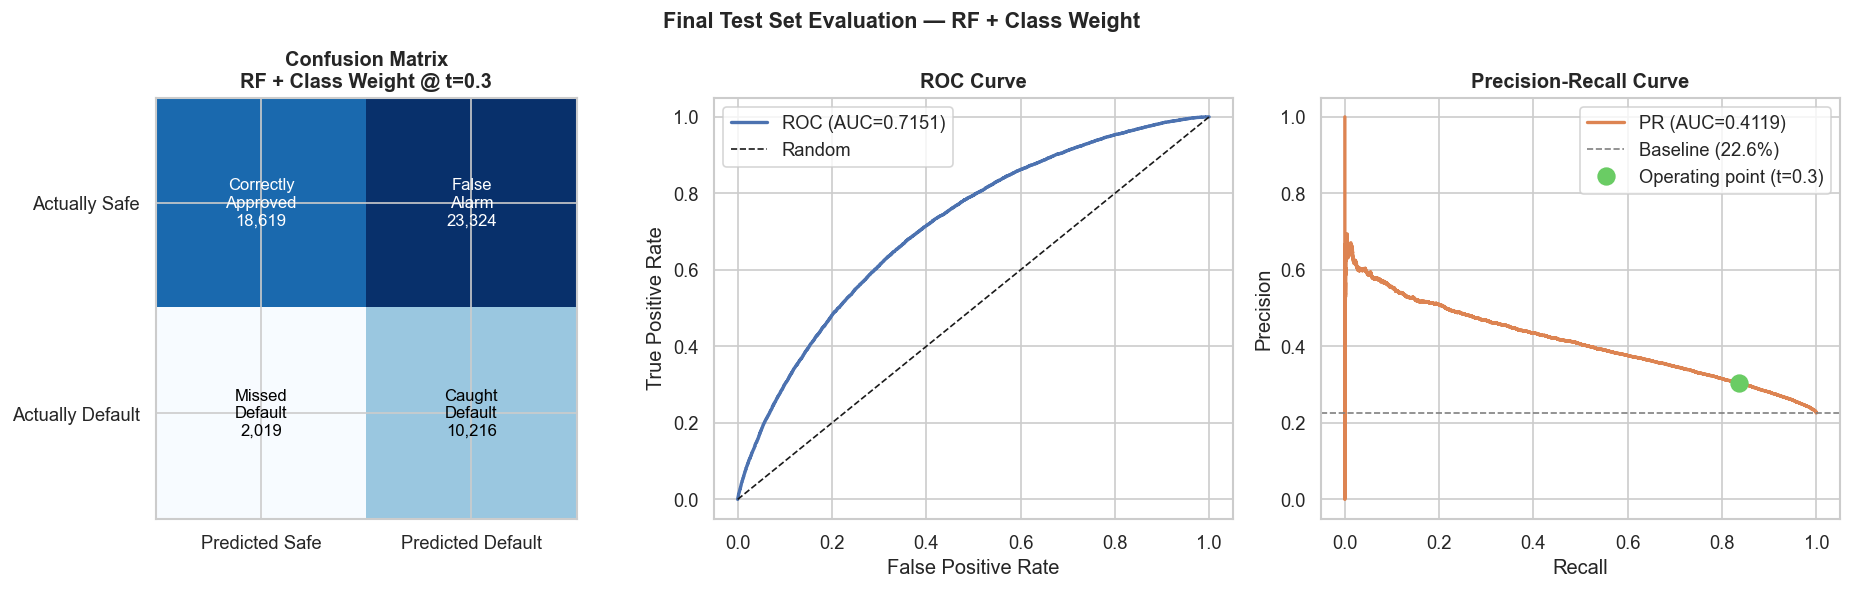


BUSINESS IMPACT — Per 10,000 Loans
  Expected defaults in portfolio:  2,258
  Defaults caught by model:        1,885  (83.5%)
  Defaults missed (slip through):  373
  Good borrowers falsely declined: 4,305

  Losses prevented:  $  15,834,000
  Losses from misses:$   3,133,200
  Forgone interest:  $   7,077,420
  Net benefit:       $   5,623,380


In [9]:
# ── Confusion matrix and curves for best model ───────────────────────────────
best = test_results[best_model_name]
best_model = models[best_model_name]
best_probs = best['probs']

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# ── Confusion matrix ──────────────────────────────────────────────────────────
cm_data = np.array([[best['tn'], best['fp']],
                    [best['fn'], best['tp']]])
cm_labels = np.array([['Correctly\nApproved', 'False\nAlarm'],
                      ['Missed\nDefault',   'Caught\nDefault']])
im = axes[0].imshow(cm_data, cmap='Blues')
for i in range(2):
    for j in range(2):
        axes[0].text(j, i, f"{cm_labels[i,j]}\n{cm_data[i,j]:,}",
                     ha='center', va='center', fontsize=10,
                     color='white' if cm_data[i,j] > cm_data.max()*0.5 else 'black')
axes[0].set_xticks([0,1]); axes[0].set_yticks([0,1])
axes[0].set_xticklabels(['Predicted Safe','Predicted Default'])
axes[0].set_yticklabels(['Actually Safe','Actually Default'])
axes[0].set_title(f'Confusion Matrix\n{best_model_name} @ t={THRESHOLD}', fontweight='bold')

# ── ROC curve ─────────────────────────────────────────────────────────────────
fpr, tpr, _ = roc_curve(y_test, best_probs)
axes[1].plot(fpr, tpr, color='#4C72B0', linewidth=2,
             label=f'ROC (AUC={best["roc_auc"]:.4f})')
axes[1].plot([0,1],[0,1], 'k--', linewidth=1, label='Random')
axes[1].set_xlabel('False Positive Rate'); axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve', fontweight='bold')
axes[1].legend()

# ── Precision-Recall curve ────────────────────────────────────────────────────
prec_curve, rec_curve, _ = precision_recall_curve(y_test, best_probs)
axes[2].plot(rec_curve, prec_curve, color='#DD8452', linewidth=2,
             label=f'PR (AUC={best["pr_auc"]:.4f})')
axes[2].axhline(y_test.mean(), color='gray', linestyle='--', linewidth=1,
                label=f'Baseline ({y_test.mean()*100:.1f}%)')
# Mark operating point
axes[2].plot(best['recall'], best['precision'], 'go', markersize=10,
             label=f'Operating point (t={THRESHOLD})')
axes[2].set_xlabel('Recall'); axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve', fontweight='bold')
axes[2].legend()

plt.suptitle(f'Final Test Set Evaluation — {best_model_name}', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/final_model_evaluation.png', bbox_inches='tight')
plt.show()

# ── Business impact translation ───────────────────────────────────────────────
n_loans      = 10_000
default_rate = y_test.mean()
avg_loan     = 12_000
avg_loss_pct = 0.70   # 70% of principal lost on default (industry estimate)
avg_int_rate = 0.137  # median from NB01; annual interest income on a good loan

n_defaults_expected = int(n_loans * default_rate)
n_caught    = int(n_defaults_expected * best['recall'])
n_missed    = n_defaults_expected - n_caught
n_good      = n_loans - n_defaults_expected
n_false_pos = int(n_good * (best['fp'] / (best['fp'] + best['tn'])))

loss_prevented  = n_caught   * avg_loan * avg_loss_pct
loss_from_miss  = n_missed   * avg_loan * avg_loss_pct
forgone_revenue = n_false_pos * avg_loan * avg_int_rate

print("\n" + "="*60)
print("BUSINESS IMPACT — Per 10,000 Loans")
print("="*60)
print(f"  Expected defaults in portfolio:  {n_defaults_expected:,}")
print(f"  Defaults caught by model:        {n_caught:,}  ({best['recall']*100:.1f}%)")
print(f"  Defaults missed (slip through):  {n_missed:,}")
print(f"  Good borrowers falsely declined: {n_false_pos:,}")
print()
print(f"  Losses prevented:  ${loss_prevented:>12,.0f}")
print(f"  Losses from misses:${loss_from_miss:>12,.0f}")
print(f"  Forgone interest:  ${forgone_revenue:>12,.0f}")
print(f"  Net benefit:       ${loss_prevented - loss_from_miss - forgone_revenue:>12,.0f}")


In [10]:
# ── Save best model and metadata ─────────────────────────────────────────────
os.makedirs('outputs', exist_ok=True)

# Save the model itself
joblib.dump(best_model, 'outputs/best_model.joblib')
print(f"Model saved: outputs/best_model.joblib")

# Save metadata as JSON — feature names, threshold, performance, hyperparameters
best_res = test_results[best_model_name]
best_params_out = rf_best_params if 'RF' in best_model_name else xgb_best_params

metadata = {
    'model_name':    best_model_name,
    'threshold':     THRESHOLD,
    'cost_ratio':    COST_RATIO,
    'train_rows':    int(len(X_train)),
    'test_rows':     int(len(X_test)),
    'features':      list(X_train.columns),
    'n_features':    int(X_train.shape[1]),
    'best_params':   {k: (int(v) if isinstance(v, (np.integer,)) else
                          float(v) if isinstance(v, (np.floating,)) else v)
                      for k, v in best_params_out.items()},
    'performance': {
        'roc_auc':   round(float(best_res['roc_auc']), 4),
        'pr_auc':    round(float(best_res['pr_auc']),  4),
        'precision': round(float(best_res['precision']), 4),
        'recall':    round(float(best_res['recall']),  4),
        'f1':        round(float(best_res['f1']),      4),
        'cost_5to1': int(best_res['cost']),
        'tp': int(best_res['tp']), 'fp': int(best_res['fp']),
        'fn': int(best_res['fn']), 'tn': int(best_res['tn']),
    }
}

with open('outputs/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Metadata saved: outputs/model_metadata.json")
print(json.dumps({k: v for k, v in metadata.items() if k != 'features'}, indent=2))


Model saved: outputs/best_model.joblib
Metadata saved: outputs/model_metadata.json
{
  "model_name": "RF + Class Weight",
  "threshold": 0.3,
  "cost_ratio": 5,
  "train_rows": 216709,
  "test_rows": 54178,
  "n_features": 53,
  "best_params": {
    "n_estimators": 200,
    "min_samples_split": 20,
    "min_samples_leaf": 8,
    "max_features": "log2",
    "max_depth": null
  },
  "performance": {
    "roc_auc": 0.7151,
    "pr_auc": 0.4119,
    "precision": 0.3046,
    "recall": 0.835,
    "f1": 0.4464,
    "cost_5to1": 33419,
    "tp": 10216,
    "fp": 23324,
    "fn": 2019,
    "tn": 18619
  }
}


---
## 🛑 Breakpoint — Model Selection

*(See conversation for user responses before proceeding to NB06)*

**Summary for discussion:**
- All four model variants evaluated on the held-out test set at threshold 0.3
- Best model selected based on 5:1 cost-weighted metric
- Model and metadata saved to `outputs/`

**Questions for the user:**
1. Do you agree with this model selection, or do you prefer a different variant based on the results?
2. Is threshold 0.3 still acceptable, or does the cost-optimal threshold from the analysis suggest a revision?
3. Ready to proceed to NB06 (SHAP Interpretability)?
